**KACPER HRYNIEWICZ** - OpenCV Hard Task 2

---

In [9]:
import seaborn_image
import torch
import numpy as np
import cv2
from torchvision import datasets, transforms
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

LOADING DATA

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

datasets.GTSRB(root='./data', split="train", download=True, transform=transform)

train_images = []
train_labels = []
classes = 43

current_path = os.getcwd() + "\\DATA\\gtsrb\\GTSRB\\Training\\"

for i in range(classes):
    path = os.path.join(current_path, str(str(i).zfill(5)))
    img_folder = os.listdir(path)
    for j in img_folder:
        try:
            image = cv2.imread(str(path+'\\'+j))
            image = cv2.resize(image, (32, 32))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = transform(image)
            train_images.append(image)
            train_labels.append(i)
        except:
            pass

datasets.GTSRB(root='./data', split="test", download=True, transform=transform)

raw_test_data = pd.read_csv(os.getcwd() + "\\DATA\\gtsrb\\GT-final_test.csv")
raw_test_data["Filename"] = raw_test_data["Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId"].str.split(";").str.get(0)
raw_test_data["Label"] = pd.to_numeric(raw_test_data["Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId"].str.split(";").str.get(-1))

test_images = []
test_image_names = []
test_labels = []

for index, row in raw_test_data.iterrows():
    test_image_names.append(row["Filename"])
    test_labels.append(row["Label"])

current_path = os.getcwd() + "\\DATA\\gtsrb\\GTSRB\\Final_Test\\Images\\"

for filename in test_image_names:
    image = cv2.imread(current_path + filename)
    image = cv2.resize(image, (32, 32))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = transform(image)
    test_images.append(image)

print("Are there as many train images as there are train labels?\n", len(train_images) == len(train_labels))
print("How about test images and test labels?\n", len(test_images) == len(test_labels))

Are there as many train images as there are train labels?
 True
How about test images and test labels?
 True


DATA INTO DATALOADERS

In [3]:
batchsize = 32

train_images = torch.stack(train_images)
train_labels = torch.tensor(train_labels)
test_images = torch.stack(test_images)
test_labels = torch.tensor(test_labels)

train_images = train_images.type(torch.FloatTensor)
train_labels = train_labels.type(torch.LongTensor)
test_images = test_images.type(torch.FloatTensor)
test_labels = test_labels.type(torch.LongTensor)

train_data = TensorDataset(train_images, train_labels)
test_data  = TensorDataset(test_images, test_labels)

train_data_loader = DataLoader(train_data, shuffle=True, batch_size=batchsize, drop_last=True)
test_data_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

print("Are the test and train images' max values equal?\n", bool(torch.max(train_images) == torch.max(test_images)))
print("What's the max test image value then?\n", float(torch.max(test_images)))

Are the test and train images' max values equal?
 True
What's the max test image value then?
 1.0


ANN ARCHITECTURE

In [117]:
numepochs = 15
dropoutrate = .875
width = 2048
secwidth = 2048

def ANN_instance():

  class ANN(nn.Module):
    def __init__(self):
      super().__init__()
      
      self.dr = dropoutrate
      insize = 3200
      
      self.conv1 = nn.Conv2d(1,16,kernel_size=5,stride=1,padding=1)
      self.conv2 = nn.Conv2d(16,32,kernel_size=5,stride=1,padding=1)
      self.bnorm1 = nn.BatchNorm2d(32)
      
      self.conv3 = nn.Conv2d(32,64,kernel_size=5,stride=1,padding=1)
      self.conv4 = nn.Conv2d(64,128,kernel_size=5,stride=1,padding=1)
      self.bnorm2 = nn.BatchNorm2d(128)
      
      self.flatten = nn.Flatten()
      
      self.fc1 = nn.Linear(insize,width)
      self.bnorm3 = nn.BatchNorm1d(width)
      
      self.fc2 = nn.Linear(width,secwidth)
      self.bnorm4 = nn.BatchNorm1d(secwidth)

      self.out = nn.Linear(secwidth,classes)

    def forward(self,x):

      x = F.max_pool2d(self.conv2(self.conv1(x)),2)
      x = F.leaky_relu(self.bnorm1(x))
      
      x = F.max_pool2d(self.conv4(self.conv3(x)),2)
      x = F.leaky_relu(self.bnorm2(x))

      x = self.flatten(x)

      x = F.relu(self.fc1(x))
      x - self.bnorm3(x)
      x = F.dropout(x, p=self.dr, training=self.training)
      
      # x = F.relu(self.fc2(x))
      # x - self.bnorm4(x)
      # x = F.dropout(x, p=self.dr, training=self.training)

      x = self.out(x)

      return x

  net = ANN()

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.AdamW(net.parameters(),lr=.001, weight_decay=0.02)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=4,gamma=1/4)

  return net,lossfun,optimizer

TRAINING

In [118]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [124]:
net, lossfun, optimizer = ANN_instance()

losses = []
train_acc = []
test_acc = []
test_prec = []
test_recall = []
test_fbeta = []

In [125]:
net.to(device)

for epochi in range(numepochs):

  net.train()
  batch_acc  = []
  batch_loss = []
  
  for X, y in train_data_loader:

    X = X.to(device)
    y = y.to(device)

    y_hat = net(X)
    loss = lossfun(y_hat,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_hat = y_hat.cpu()
    y = y.cpu()

    batch_loss.append(loss.item())

    matches = torch.argmax(y_hat, axis=1) == y
    matches_num = matches.float()
    accuracy_pic = 100*torch.mean(matches_num)
    batch_acc.append(accuracy_pic)

  currtrain_acc = np.mean(batch_acc)
  train_acc.append(currtrain_acc)

  currloss = np.mean(batch_loss)
  losses.append(currloss)

  net.eval()
  X, y = next(iter(test_data_loader))
  
  X = X.to(device)
  y = y.to(device)
  
  with torch.no_grad():
    y_hat = net(X)

  y_hat = y_hat.cpu()
  y = y.cpu()

  y_hat = torch.argmax(y_hat, dim = 1)
  curracc = 100*torch.mean((y_hat==y).float())
  test_acc.append(curracc)

  prec_rec_fbeta = precision_recall_fscore_support(y, y_hat, average='macro')
  test_prec.append(prec_rec_fbeta[0])
  test_recall.append(prec_rec_fbeta[1])
  test_fbeta.append(prec_rec_fbeta[2])
  
  print(f"Epoch {(epochi)}".ljust(8, " ") + f" | Loss: {round(float(currloss),3)}".ljust(14, " ") + f" | Training Accuracy: {round(float(currtrain_acc),1)}% | Test Accuracy: {round(float(curracc),1)}%")
  
  if currtrain_acc-1 >= curracc and curracc >= 96.5:
    break


c:\Users\aweth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0  | Loss: 2.227 | Training Accuracy: 38.6% | Test Accuracy: 81.7%


c:\Users\aweth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1  | Loss: 0.927 | Training Accuracy: 71.1% | Test Accuracy: 90.7%
Epoch 2  | Loss: 0.579 | Training Accuracy: 81.9% | Test Accuracy: 94.6%
Epoch 3  | Loss: 0.363 | Training Accuracy: 88.7% | Test Accuracy: 95.1%
Epoch 4  | Loss: 0.248 | Training Accuracy: 92.6% | Test Accuracy: 95.5%
Epoch 5  | Loss: 0.169 | Training Accuracy: 95.1% | Test Accuracy: 95.6%
Epoch 6  | Loss: 0.12  | Training Accuracy: 96.6% | Test Accuracy: 96.3%
Epoch 7  | Loss: 0.091 | Training Accuracy: 97.6% | Test Accuracy: 95.6%
Epoch 8  | Loss: 0.081 | Training Accuracy: 97.8% | Test Accuracy: 96.6%


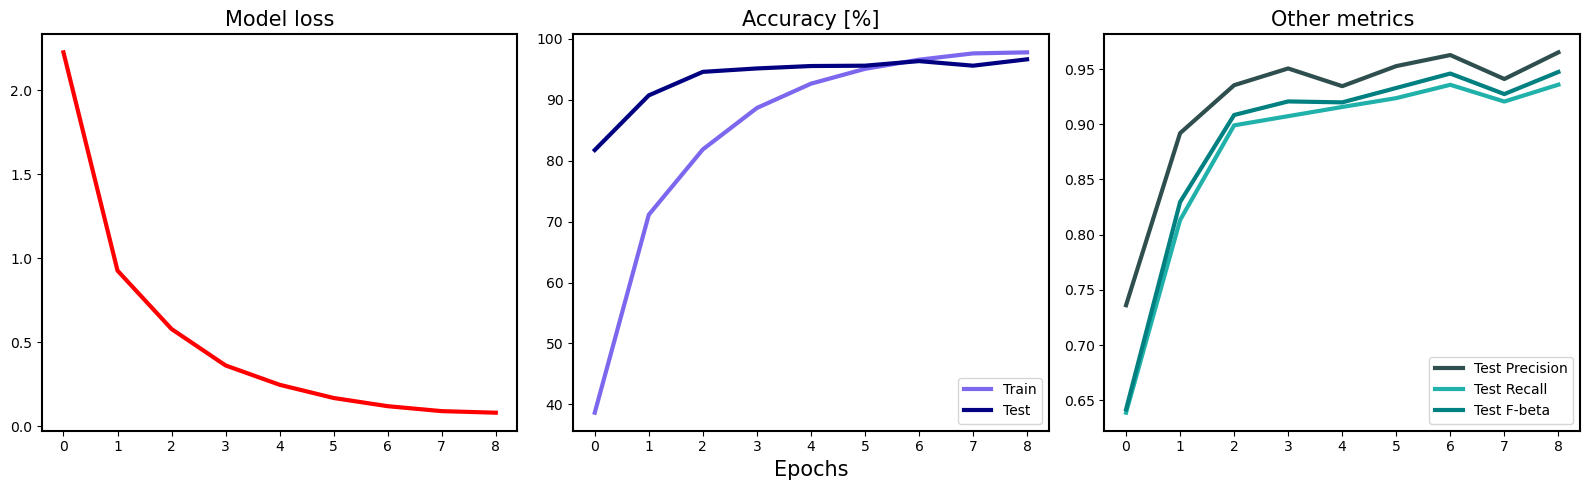

In [126]:
fig,ax = plt.subplots(1, 3, figsize=(16,5))

ax[0].plot(losses, linewidth=3, color="red")
ax[0].set_title('Model loss')

ax[1].plot(train_acc,label='Train', linewidth=3, color="mediumslateblue")
ax[1].plot(test_acc,label='Test', linewidth=3, color="navy")
ax[1].set_xlabel('Epochs')
ax[1].set_title('Accuracy [%]')
ax[1].legend(loc=4)

ax[2].plot(test_prec,label='Test Precision', linewidth=3, color="darkslategray")
ax[2].plot(test_recall,label='Test Recall', linewidth=3, color="lightseagreen")
ax[2].plot(test_fbeta,label='Test F-beta', linewidth=3, color="teal")
ax[2].set_title('Other metrics')
ax[2].legend(loc=4)

fig.tight_layout()
plt.show()